In [10]:
# Train model to predict the type of news from a headline, on dataset AG_NEWS

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.nn import Embedding, Linear, RNN
import os

import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime

# use Huggingface Datasets API b/c PyTorch's built-in TorchText is deprecated
# HuggingFace also requires less boilerplate, so it's a win-win
from datasets import load_dataset
from datasets import load_dataset_builder
from tokenizers import Tokenizer, normalizers, pre_tokenizers, processors
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from transformers import PreTrainedTokenizerFast

In [11]:
# print some information on the dataset
ds_builder = load_dataset_builder("fancyzhx/ag_news")
train_dataset = load_dataset("fancyzhx/ag_news", split="train")
val_dataset = load_dataset("fancyzhx/ag_news", split="test")

print(f"Structure of dataset:\n\t{train_dataset}")
print(f"Datatypes in dataset:\n\t{ds_builder.info.features}")
print(f"Example from dataset:\n\t{train_dataset[0]}")

Structure of dataset:
	Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})
Datatypes in dataset:
	{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}
Example from dataset:
	{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [17]:
# Train the tokenizer

# HF Tokenizers train new vocabularies and tokenizer, and you may design customized tokenization 
# flow with Normalization, Pre-tokenization, Model, Post-tokenization, etc. These are low-level, so
# requires boilerplate code to use with minibatches of data
# The Transformers Tokenizer API handles that boilerplate code, so we create a custom Tokenizer 
# and wrap it in a Transformers Tokenizer.

# Notice Wordpiece learns to split token, and can encounter unknown tokens
# ByteLevel pretokenizer removes this issue
# Also, we should really only use the training dataset to train the tokenizer
# see https://huggingface.co/docs/transformers/en/tokenizer_summary
# then https://huggingface.co/docs/tokenizers/pipeline
# then https://huggingface.co/docs/tokenizers/components

seqlength = 50

tokenizer = Tokenizer(WordPiece())
tokenizer.normalizer = normalizers.Sequence([normalizers.Lowercase(), normalizers.Strip()])
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([pre_tokenizers.Punctuation(), pre_tokenizers.ByteLevel()])

trainer = WordPieceTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], min_frequency=30)

# Iterator using the text form complex_sentence
def iterator_agnews(train_dataset, val_dataset):
  for mydataset in [train_dataset, val_dataset]:
    for i, data in enumerate(mydataset):
      if isinstance(data.get("text", None), str):
        yield data["text"]

tokenizer.train_from_iterator(iterator_agnews(train_dataset, val_dataset), trainer=trainer)

# add postprocessing
tokenizer.post_processor = processors.TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ])

# truncate and pad so that minibatches will all consists of examples 
# with same sequence length
tokenizer.enable_padding(pad_token='[PAD]', length=seqlength)
tokenizer.enable_truncation(max_length=seqlength)

# show number of tokens learned
print(f"Number of tokens learned: {tokenizer.get_vocab_size()}")

# wrap the tokenizer so we can easily apply it to minibatches
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    pad_token="[PAD]",
    bos_token="[BOS]",
    eos_token="[EOS]",
    model_max_length=seqlength
)




Number of tokens learned: 17731


In [19]:
#check the Tokenizer and Transformer Tokenizer give the same output

exampletext = train_dataset[0]['text']

output = tokenizer.encode(exampletext)
print(f"Raw input: \n\t {exampletext}\n")
print(f"Tokenized input: \n\t {output.tokens}\n")
print(f"Ids fed into RNN model: \n\t {output.ids}\n")

print(f"Output of Transformer tokenizer: {wrapped_tokenizer(exampletext, padding='max_length', truncation=True).input_ids}")

Raw input: 
	 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Tokenized input: 
	 ['[BOS]', 'Ġwall', 'Ġst', 'Ġ.', 'Ġbears', 'Ġclaw', 'Ġback', 'Ġinto', 'Ġthe', 'Ġblack', 'Ġ', 'Ġ(', 'Ġreuters', 'Ġ)', 'Ġreuters', 'Ġ', 'Ġ-', 'Ġshort', 'Ġ-', 'Ġsellers', 'Ġ,', 'Ġwall', 'Ġstreet', "Ġ'", 'Ġs', 'Ġdwindling', 'Ġ\\', 'Ġband', 'Ġof', 'Ġultra', 'Ġ-', 'Ġcy', '##nic', '##s', 'Ġ,', 'Ġare', 'Ġseeing', 'Ġgreen', 'Ġagain', 'Ġ.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Ids fed into RNN model: 
	 [1, 1480, 174, 125, 4012, 16720, 592, 536, 124, 1818, 58, 198, 287, 200, 287, 58, 148, 1625, 148, 13647, 141, 1480, 1531, 220, 118, 16638, 243, 4152, 152, 10294, 148, 2068, 7203, 66, 141, 374, 7742, 1974, 444, 125, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Output of Transformer tokenizer: [1, 1480, 174, 125, 4012, 16720, 592, 536, 124, 1818, 58, 198, 287, 200, 287, 58, 148, 1625

In [5]:
# Tokenize the training and test datasets

train_dataset = train_dataset.map(lambda e: wrapped_tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
val_dataset = val_dataset.map(lambda e: wrapped_tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
train_dataset.set_format(type = 'torch', columns=['input_ids', 'label'])
val_dataset.set_format(type = 'torch', columns=['text', 'input_ids', 'label'])

train_loader = DataLoader(train_dataset, batch_size = 100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 100, shuffle=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
# Classifier network using RNN:
# an embedding layer that converts the token indices to vectors
# an RNN that takes the input vector sequence and returns the corresponding sequence of hidden states
# extract the last hidden state and use a linear layer to convert to logits

class RNNclassifier(nn.Module):

    def __init__(self, vocabsize, numclasses, embedding_dim, hidden_size, num_layers=1, nonlinearity="tanh"):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embeddings = Embedding(vocabsize, embedding_dim)
        self.RNN = RNN(embedding_dim, hidden_size, num_layers, nonlinearity=nonlinearity)
        self.logits = Linear(hidden_size, numclasses)
        
    def forward(self, x):
        # NB: expect inputs to have  shape [len_of_sequence, batchsize]
        # embedding layer converts to [len_of_sequence, batchsize, embedding_dim]
        x = self.embeddings(x)
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        hiddenStates, _ = self.RNN(x, h0)
        out = hiddenStates[-1, :, :] # use the last hidden state as the inputs to the logit layer
        return self.logits(out)

In [7]:
# Standard training infrastructure

def train_epoch(model, criterion, optimizer, trainloader, clip=1, verbose=True, interval=100):
    model.train()
    numbatches = len(trainloader)
    for (idx, batch) in enumerate(trainloader):
        inputs = batch['input_ids'].t()
        targets = batch['label']
        inputs.to(device)
        targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #clip_grad_norm_(model.parameters(), clip) # gradient clipping can help
        optimizer.step()
        if (idx + 1) % interval == 0:
            if verbose: 
                print(f"\tTraining loss on minibatch {idx+1}/{numbatches}: {loss.item()/len(targets):>5f}")

def validate(model, criterion, valloader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    numsamples = len(valloader.dataset)
    with torch.no_grad():
        for (idx, batch) in enumerate(valloader):
            inputs = batch['input_ids'].t()
            targets = batch['label']
            inputs.to(device)
            targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
    loss = test_loss/numsamples
    accuracy = 100*correct/numsamples
    if verbose:
        print(f"\tValidation loss/accuracy: {loss:>5f}/{accuracy:>5f}")
    return loss, accuracy

cpu


In [8]:
# Train

embedding_dim = 100
hidden_size = 300
lr = 0.001
epochs = 45
vocabsize = wrapped_tokenizer.vocab_size

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = RNNclassifier(vocabsize, 4, embedding_dim, hidden_size, num_layers=2, nonlinearity="relu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

val_losses = []
train_losses = []
val_accuracies = []
train_accuracies = []
verbose = True
best_val = torch.inf
best_epoch = 0

print(f"Training AGNews RNN classification model on {device}")
print("---------------------------------------------")

trainstart = time.time()
for e in range(epochs):
    epochstart = time.time()
    print(f"Epoch {e+1}/{epochs} (lr={scheduler.get_last_lr()}):")
    train_epoch(model, criterion, optimizer, train_loader, verbose=verbose, interval=100)
    scheduler.step()
    train_loss, train_accuracy = validate(model, criterion, train_loader, verbose=False)
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    if val_loss < best_val:
        print(f"\tCurrent best model")
        best_val = val_loss
        best_epoch = e
        torch.save(model.state_dict(), 'best_newsmodel_weights.pth')
    print(f"\tTime elapsed: {datetime.timedelta(seconds=time.time()-epochstart)}")
    
print(f"\nTotal training time: {datetime.timedelta(seconds=time.time() - trainstart)}")
print(f"Best model found at epoch {best_epoch + 1}")

Training yelp review RNN classification model on cpu
---------------------------------------------
Epoch 1/45 (lr=[0.001]):
	Training loss on minibatch 100/1200: 0.013539
	Training loss on minibatch 200/1200: 0.013819
	Training loss on minibatch 300/1200: 0.012208
	Training loss on minibatch 400/1200: 0.008717
	Training loss on minibatch 500/1200: 0.009430
	Training loss on minibatch 600/1200: 0.012796
	Training loss on minibatch 700/1200: 0.010388
	Training loss on minibatch 800/1200: 0.011855
	Training loss on minibatch 900/1200: 0.009267
	Training loss on minibatch 1000/1200: 0.009402
	Training loss on minibatch 1100/1200: 0.008461
	Training loss on minibatch 1200/1200: 0.008012
	Validation loss/accuracy: 0.007566/68.776316
	Current best model
	Time elapsed: 0:01:07.024621
Epoch 2/45 (lr=[0.001]):
	Training loss on minibatch 100/1200: 0.008796
	Training loss on minibatch 200/1200: 0.006881
	Training loss on minibatch 300/1200: 0.006576
	Training loss on minibatch 400/1200: 0.005353


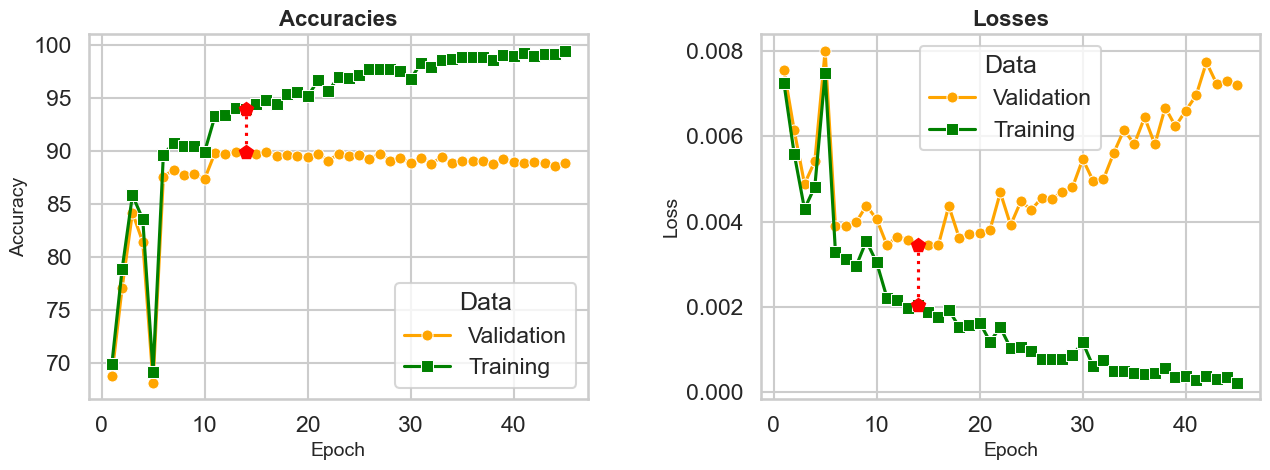

In [9]:
# Visualize the training of the model

# Set Seaborn style
sns.set(style="whitegrid", context="talk", palette="deep")

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

indices = torch.arange(epochs)+1

# Plot Validation and Training Accuracies
sns.lineplot(x=indices, y=val_accuracies, marker="o", markersize=8, color="orange", label="Validation", ax=ax1)
sns.lineplot(x=indices, y=train_accuracies, marker="s", markersize=8, color="green", label="Training", ax=ax1)
ax1.set_title("Accuracies", fontsize=16, weight="bold")
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=14)
ax1.legend(title="Data")

# Plot Validation and Training Losses
sns.lineplot(x=indices, y=val_losses, marker="o", markersize=8, color="orange", label="Validation", ax=ax2)
sns.lineplot(x=indices, y=train_losses, marker="s", markersize=8, color="green", label="Training", ax=ax2)
ax2.set_title("Losses", fontsize=16, weight="bold")
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Loss", fontsize=14)
ax2.legend(title="Data")

# Add a large red dot at epoch of best model for losses and accuracies
ax1.plot(best_epoch+1, train_accuracies[best_epoch], 'p', color='red', markersize=10)
ax1.plot(best_epoch+1, val_accuracies[best_epoch], 'p', color='red', markersize=10)
ax2.plot(best_epoch+1, train_losses[best_epoch], 'p', color='red', markersize=10)
ax2.plot(best_epoch+1, val_losses[best_epoch], 'p', color='red', markersize=10)

# Draw a vertical line between training and validation losses and accuracies at epoch w/ best model
ax1.vlines(x=best_epoch+1, ymin=val_accuracies[best_epoch], ymax=train_accuracies[best_epoch],  
               color='red', linestyle=':')
ax2.vlines(x=best_epoch+1, ymin=train_losses[best_epoch], ymax=val_losses[best_epoch], 
               color='red', linestyle=':')

# Adjust layout
fig.tight_layout(pad=3.0)
plt.show()
